<a href="https://colab.research.google.com/github/AMAYadav/PROJECTS-/blob/main/APPLE_TIME_SEIRES_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
# !pip install prophet

     |████████████████████████████████| 6.3 MB 6.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

In [ ]:
import yfinance as yf

df = yf.download(tickers='AAPL',period='2y',interval='1d',rounding='3',progress=False)['Adj Close']
df=pd.DataFrame(df)
df.head()
df.tail()

,Adj Close
Date,
2021-11-08,150.44
2021-11-09,150.81
2021-11-10,147.92
2021-11-11,147.87
2021-11-12,149.99


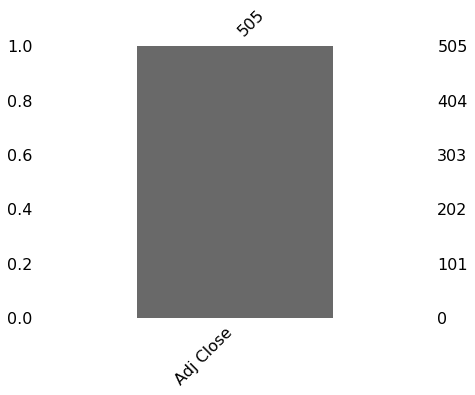

In [ ]:
ms.bar(df,figsize=(7,5))

In [ ]:
df.isnull().sum()
df.info()
df.describe()
df.shape
df.columns

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2019-11-13 to 2021-11-12
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  505 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


Index(['Adj Close'], dtype='object')

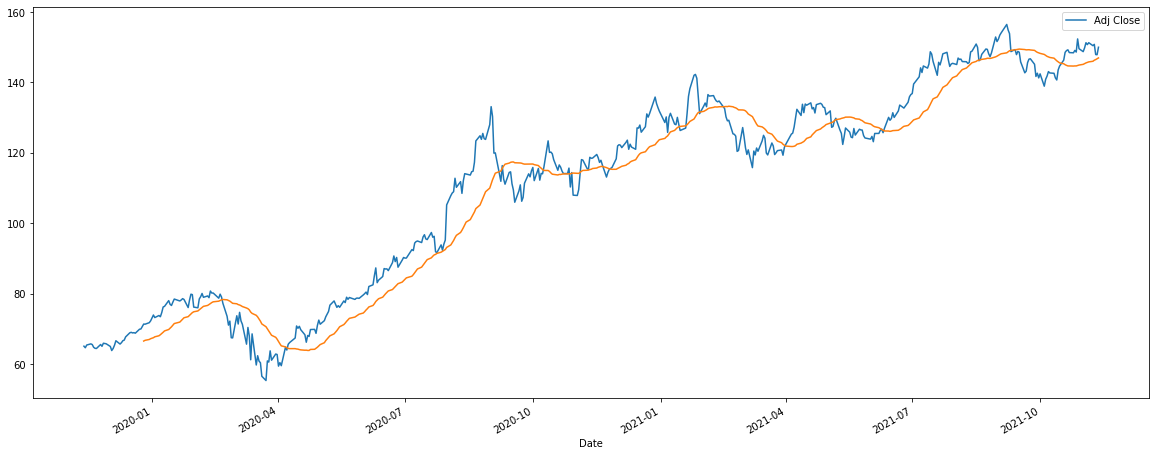

In [ ]:
df.plot()
df['Adj Close'].rolling(30).mean().dropna().plot(figsize=(20,8))
plt.savefig('graph.png',dpi=500)

In [ ]:
df.reset_index(drop=False,inplace=True)
df.rename(columns={'Date':'ds','Adj Close':'y'},inplace=True)
df.count()

ds    505
y     505
dtype: int64

In [ ]:
df_train1= df.loc[:300]
df_test1= df.loc[299:]

In [ ]:
#train_test split
# df_train=df['ds'].apply(lambda x: x.year)<2021
# trainset=df.loc[df_train].dropna()
# testset=df.loc[~df_train].reset_index(drop=True)

In [ ]:
from fbprophet import Prophet
m = Prophet()
m.add_seasonality(name='monthly', period=21, fourier_order=5)
m.fit(df_train1) 
future = m.make_future_dataframe(periods=305)
prediction= m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


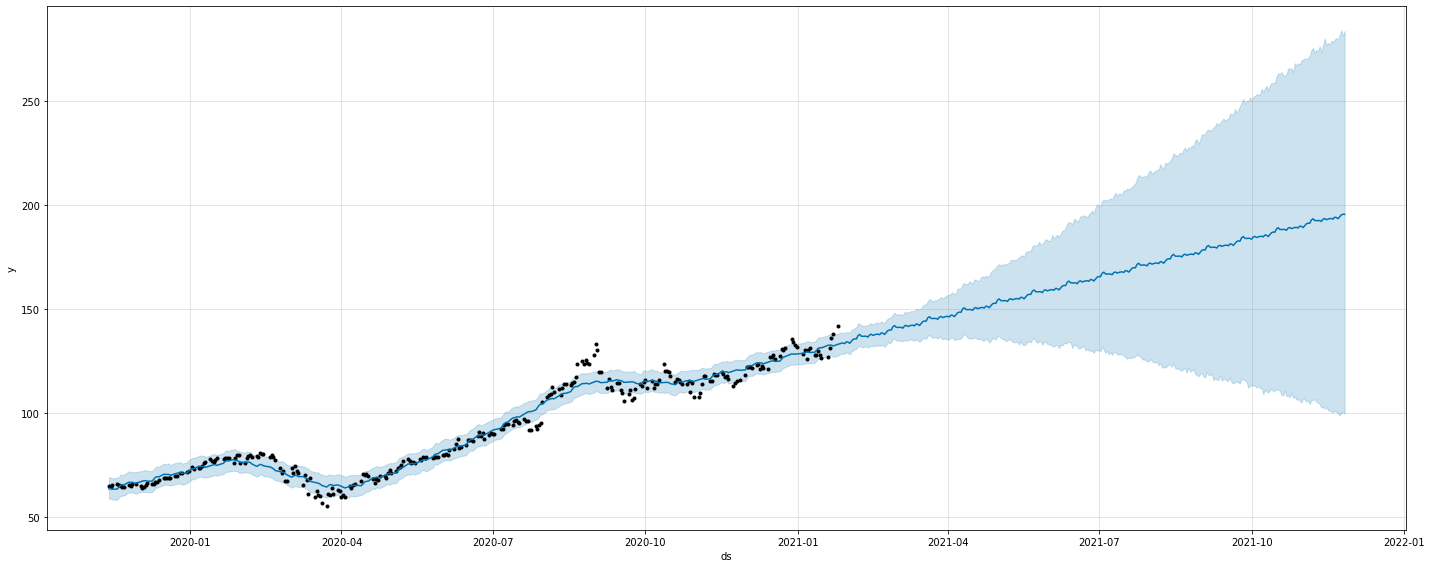

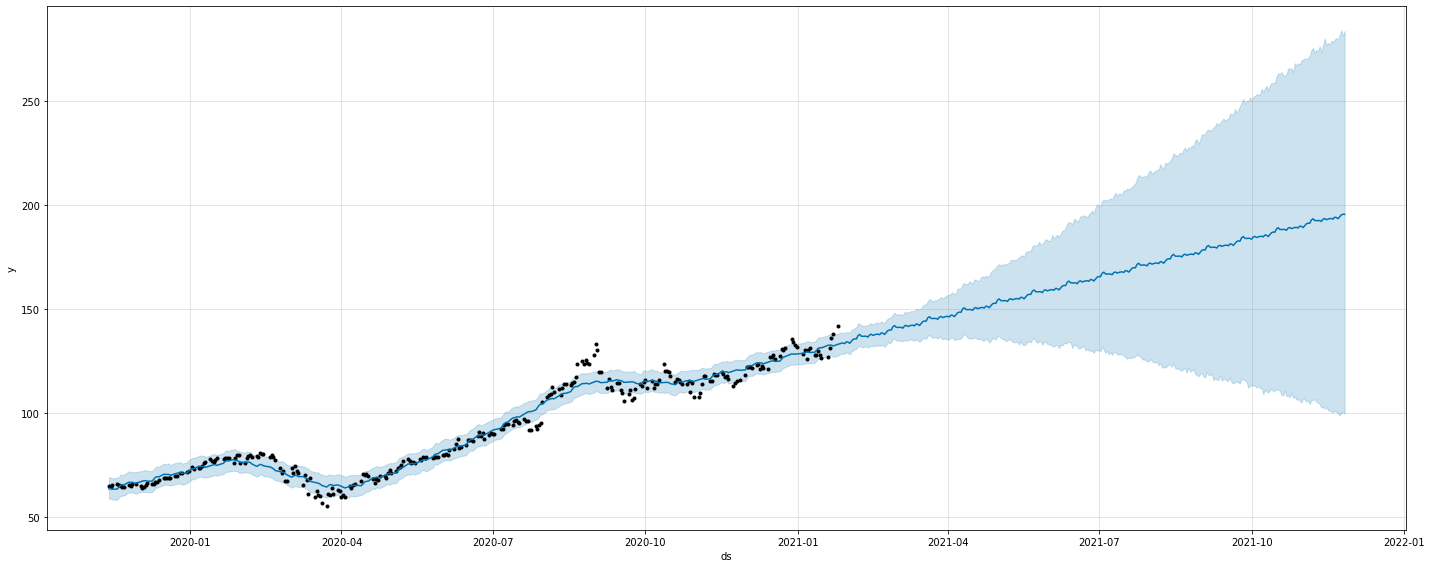

In [ ]:
fig1= m.plot(prediction,figsize=(20,8))
fig1

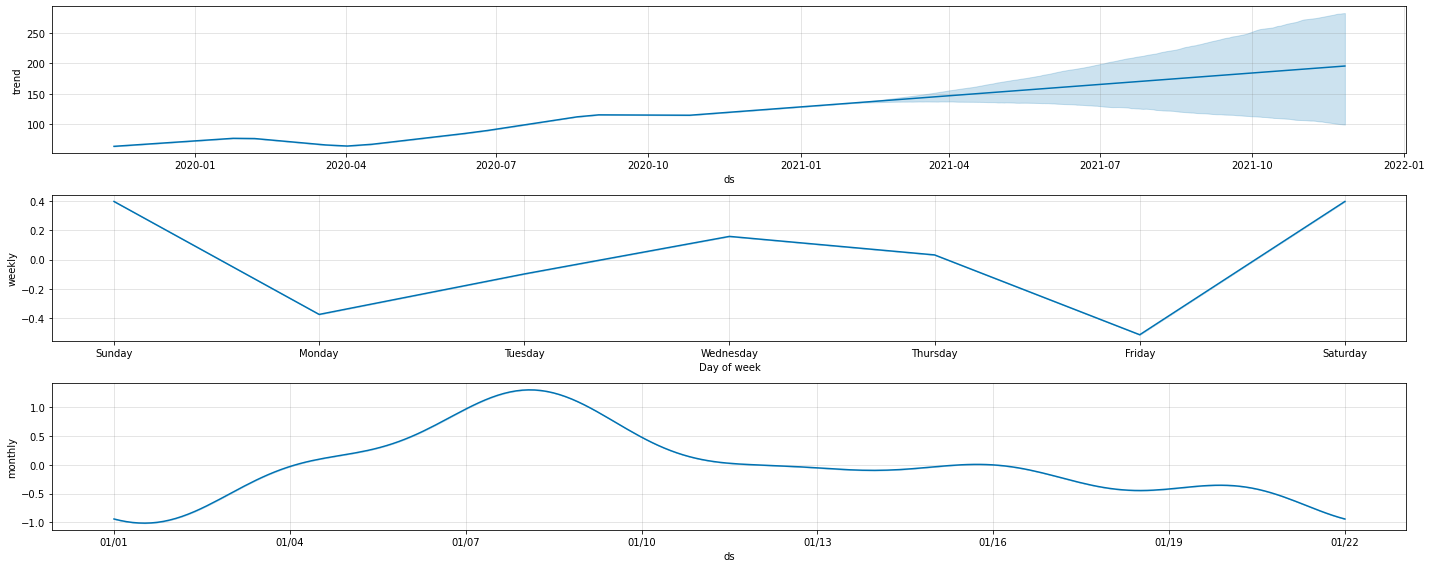

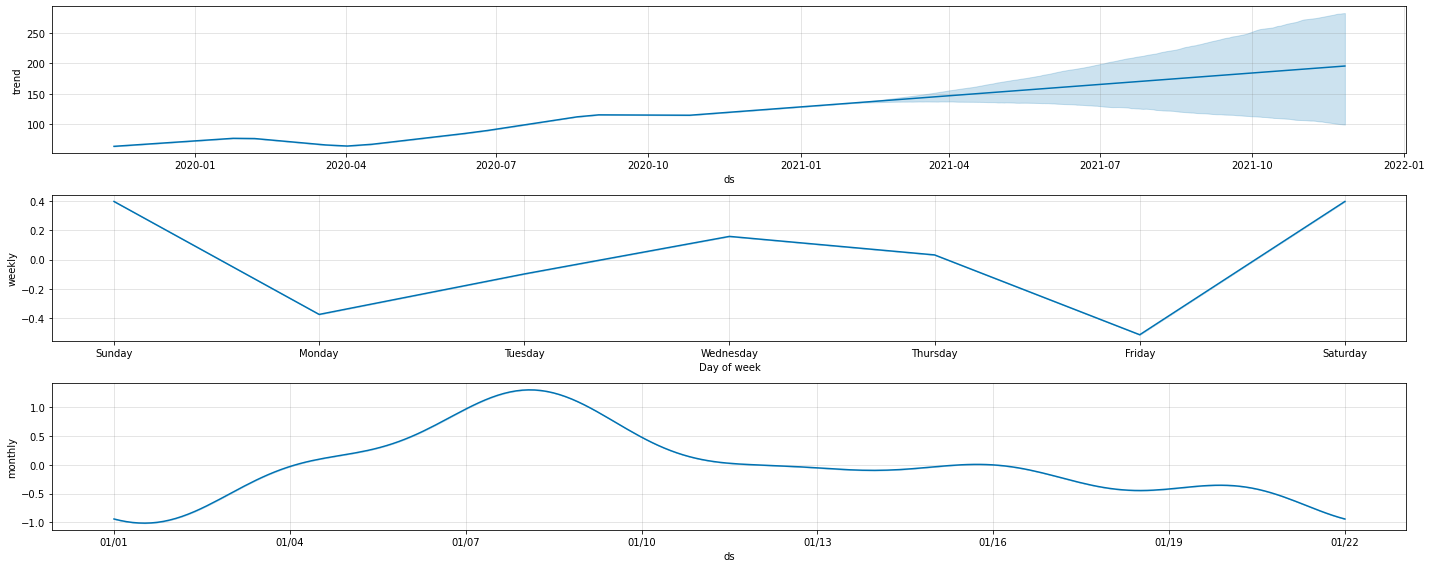

In [ ]:
m.plot_components(prediction,figsize=(20,8))

In [ ]:
#prediction.columns
prediction.count()

ds                            606
trend                         606
yhat_lower                    606
yhat_upper                    606
trend_lower                   606
trend_upper                   606
additive_terms                606
additive_terms_lower          606
additive_terms_upper          606
monthly                       606
monthly_lower                 606
monthly_upper                 606
weekly                        606
weekly_lower                  606
weekly_upper                  606
multiplicative_terms          606
multiplicative_terms_lower    606
multiplicative_terms_upper    606
yhat                          606
dtype: int64

In [ ]:
prediction_segment =prediction[['ds','yhat_lower','yhat_upper','yhat']]

In [ ]:
prediction_segment.tail()

,ds,yhat_lower,yhat_upper,yhat
601,2021-11-22,99.803987,279.436303,193.435485
602,2021-11-23,98.941288,281.741200,194.372112
603,2021-11-24,100.131259,284.020366,195.292235
604,2021-11-25,100.486800,281.288931,195.585032
605,2021-11-26,99.867026,283.627405,195.515908


In [ ]:
merged_test_predict_segment=df_test1.merge(prediction_segment,on='ds',how='left')

In [ ]:
#conveting  ds into timestemp
merged_test_predict_segment['ds']=pd.to_datetime(merged_test_predict_segment['ds'])
#del merged_test_predict_segment['index']

#set ds as index
merged_test_predict_segment =merged_test_predict_segment.set_index('ds')


In [ ]:
merged_test_predict_segment.rename(columns={'date':'y'},inplace=True)
merged_test_predict_segment.head()

,y,yhat_lower,yhat_upper,yhat
ds,,,,
2021-01-22,138.22,127.088984,137.464051,132.295557
2021-01-25,142.04,127.651939,138.174515,133.097771
2021-01-26,142.28,128.283024,138.457085,133.398003
2021-01-27,141.19,128.464992,138.893089,133.628985
2021-01-28,136.25,128.613096,138.340626,133.697369


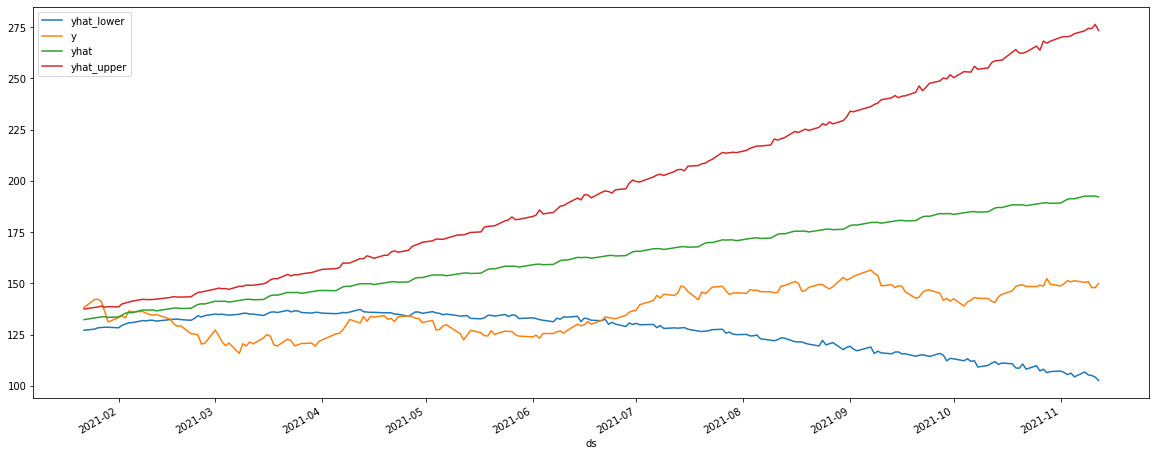

In [ ]:
merged_test_predict_segment[['yhat_lower','y','yhat','yhat_upper']].plot(figsize=(20,8))

In [ ]:
merged_test_predict_segment.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 206 entries, 2021-01-22 to 2021-11-12
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   y           206 non-null    float64
 1   yhat_lower  206 non-null    float64
 2   yhat_upper  206 non-null    float64
 3   yhat        206 non-null    float64
dtypes: float64(4)
memory usage: 8.0 KB


[Text(0, 0.5, 'APPLE STOCK PRICE'),
 Text(0.5, 0, 'DATE'),
 Text(0.5, 1.0, 'APPLE PRICE- ACTUAL VS PREDICTED')]

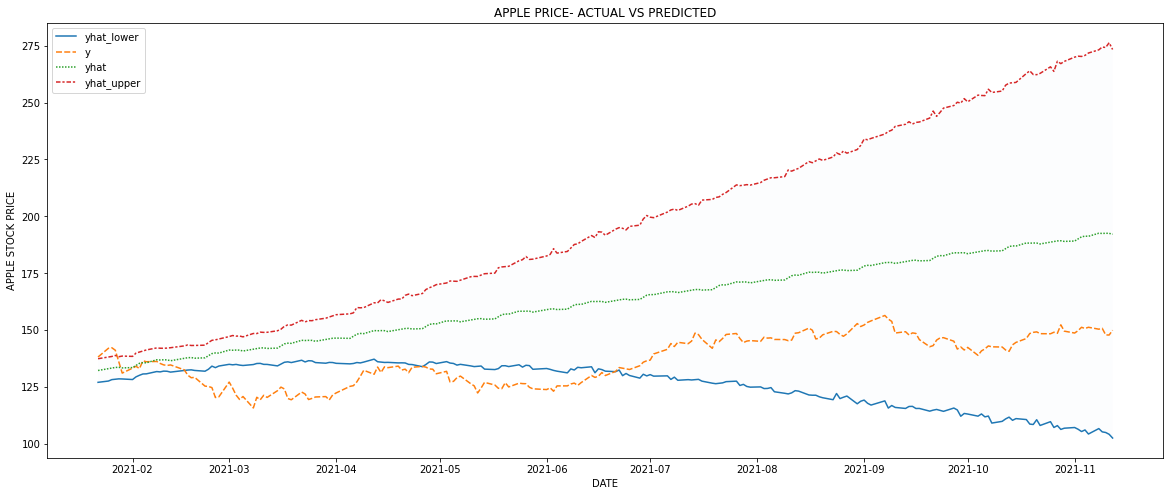

In [ ]:
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(20,8))
ax=sns.lineplot(data=merged_test_predict_segment[['yhat_lower','y','yhat','yhat_upper']])
ax.fill_between(merged_test_predict_segment.index
                ,merged_test_predict_segment.yhat_lower,
                merged_test_predict_segment.yhat_upper,
                alpha=.01)
ax.set(title='APPLE PRICE- ACTUAL VS PREDICTED',xlabel='DATE',ylabel='APPLE STOCK PRICE')

In [ ]:
#cross_validation

# from fbprophet.diagnostics import  cross_validation,performance_metrics

# cv=cross_validation(m,initial='25 days',horizon='300 days',period='30 days')
# perf_cv=performance_metrics(cv)
# perf_cv.head()

In [ ]:
# cv.head()

In [ ]:
# cv[['yhat_lower','y','yhat_upper']].plot()

In [ ]:
# from fbprophet.plot import plot_cross_validation_metric
# fig_cv=plot_cross_validation_metric(cv,metric='mape')

ARIMA MODEL

In [14]:
!pip install pmdarima

In [12]:
import pmdarima as pm

In [13]:
from pmdarima import preprocessing

In [ ]:
import yfinance as yf

ad = yf.download(tickers='AAPL',period='2y',interval='1d',rounding='3',progress=False)['Adj Close']
ad_1=pd.DataFrame(ad)
ad_1.head()

,Adj Close
Date,
2019-11-13,65.15
2019-11-14,64.70
2019-11-15,65.47
2019-11-18,65.80
2019-11-19,65.60


/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


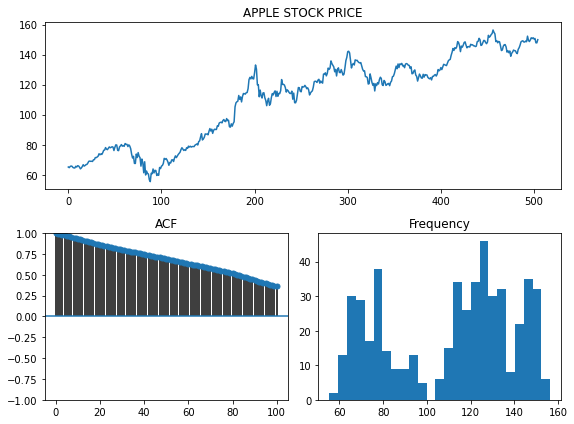

In [ ]:
#Quick display of the series
from pmdarima.utils import tsdisplay
tsdisplay(ad_1, lag_max=100,show=True,title='APPLE STOCK PRICE')


# from pmdarima.preprocessing import LogEndogTransformer
# ad_1_log, _ = LogEndogTransformer(lmbda=1e-6).fit_transform(ad_1)
# tsdisplay(ad_1_log, lag_max=100)



/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


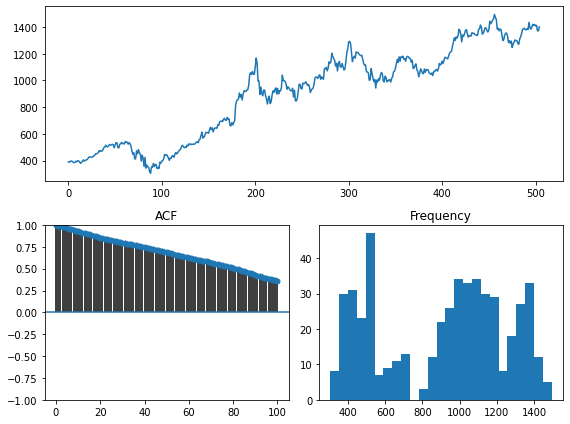

NormaltestResult(statistic=764.0561572623222, pvalue=1.2226819991548537e-166)

In [ ]:
from pmdarima.preprocessing import BoxCoxEndogTransformer

y_train_bc, _ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(ad_1)
tsdisplay(y_train_bc, lag_max=100)

#normality test
from scipy.stats import normaltest
normaltest(y_train_bc)
# normaltest(y_train_bc)[1]


In [ ]:
#Granular display of data
from pmdarima import arima


ts_1 = arima.decompose(np.ravel(ad_1),m=18,type_='multiplicative')
figure_kwargs = {'figsize': (20, 8)}
plot1= utils.decomposed_plot(ts_1,figure_kwargs=figure_kwargs)

NameError: ignored

/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


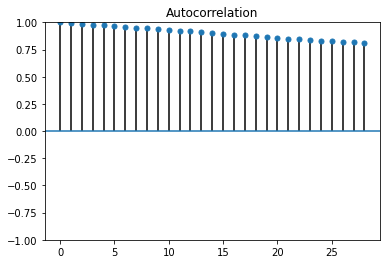

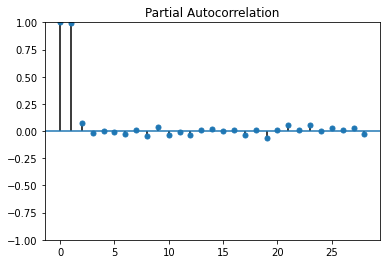

In [ ]:
from pmdarima.utils import plot_acf,plot_pacf,acf,pacf
acf_plot=  plot_acf(ad_1, show=True) 
pacf_plot=plot_pacf(ad_1, show=True)

# acf(ad_1,alpha=.05,adjusted=None)

In [ ]:
from pmdarima.arima.stationarity import ADFTest,KPSSTest
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(ad_1)
p_val

KPSSTest()

## WE DONT NEED TO CHECK OR CALC THE STATIONARITY WE CAN DIRECTLY FIND THE
# ORDER BY DOING THE NDIFF TEST WHICH ITSELF CALCS THE VALUE IF THERE ARE 
# ANY VALUE THEN IT IMPLIES THAT STATIONARITY IS REQUIRED OTHER WISE WE DONT 
# DO THAT

from pmdarima.arima.utils import ndiffs,nsdiffs
n_adf = ndiffs(ad_1, test='adf') #  test=['adf','kpss','pp]
n_adf

# Pre-compute d or D. You can use the pmdarima.arima.ndiffs() and pmdarima.arima.nsdiffs() 

# Try using exogenous features instead of a seasonal fit. Sometimes, 
# using fourier exogenous variables will remove the need for a seasonal model.
# See pmdarima.preprocessing.FourierFeaturizer for more information

from pmdarima.preprocessing import BoxCoxEndogTransformer,FourierFeaturizer


import pmdarima as pm
auto = pm.auto_arima(ad_1, d=50, seasonal=True, stepwise=False,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)
auto
print(auto.order)

 ARIMA(0,50,0)(0,0,0)[1]             : AIC=226.160, Time=0.55 sec
 ARIMA(0,50,1)(0,0,0)[1]             : AIC=4.000, Time=0.75 sec
 ARIMA(0,50,2)(0,0,0)[1]             : AIC=6.000, Time=5.56 sec
 ARIMA(0,50,3)(0,0,0)[1]             : AIC=8.000, Time=14.77 sec
 ARIMA(0,50,4)(0,0,0)[1]             : AIC=10.000, Time=1.53 sec
 ARIMA(0,50,5)(0,0,0)[1]             : AIC=12.000, Time=19.42 sec
 ARIMA(1,50,0)(0,0,0)[1]             : AIC=4.000, Time=0.62 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(1,50,1)(0,0,0)[1]             : AIC=6.000, Time=0.76 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(1,50,2)(0,0,0)[1]             : AIC=8.000, Time=5.64 sec
 ARIMA(1,50,3)(0,0,0)[1]             : AIC=10.000, Time=13.85 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(1,50,4)(0,0,0)[1]             : AIC=12.000, Time=8.64 sec
 ARIMA(1,50,5)(0,0,0)[1]             : AIC=14.000, Time=18.70 sec
 ARIMA(2,50,0)(0,0,0)[1]             : AIC=6.000, Time=0.74 sec
 ARIMA(2,50,1)(0,0,0)[1]             : AIC=8.000, Time=10.66 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(2,50,2)(0,0,0)[1]             : AIC=10.000, Time=6.81 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(2,50,3)(0,0,0)[1]             : AIC=12.000, Time=1.32 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(2,50,4)(0,0,0)[1]             : AIC=14.000, Time=1.58 sec
 ARIMA(2,50,5)(0,0,0)[1]             : AIC=16.000, Time=21.01 sec
 ARIMA(3,50,0)(0,0,0)[1]             : AIC=8.000, Time=0.96 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(3,50,1)(0,0,0)[1]             : AIC=10.000, Time=6.70 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(3,50,2)(0,0,0)[1]             : AIC=12.000, Time=7.77 sec
 ARIMA(3,50,3)(0,0,0)[1]             : AIC=14.000, Time=18.31 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(3,50,4)(0,0,0)[1]             : AIC=16.000, Time=1.73 sec
 ARIMA(3,50,5)(0,0,0)[1]             : AIC=18.000, Time=23.92 sec
 ARIMA(4,50,0)(0,0,0)[1]             : AIC=10.000, Time=6.71 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(4,50,1)(0,0,0)[1]             : AIC=12.000, Time=7.72 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(4,50,2)(0,0,0)[1]             : AIC=14.000, Time=1.43 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(4,50,3)(0,0,0)[1]             : AIC=16.000, Time=9.85 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(4,50,4)(0,0,0)[1]             : AIC=18.000, Time=12.16 sec
 ARIMA(4,50,5)(0,0,0)[1]             : AIC=20.000, Time=26.21 sec
 ARIMA(5,50,0)(0,0,0)[1]             : AIC=12.000, Time=8.60 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

divide by zero encountered in reciprocal

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(5,50,1)(0,0,0)[1]             : AIC=14.000, Time=9.82 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(5,50,2)(0,0,0)[1]             : AIC=16.000, Time=11.04 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(5,50,3)(0,0,0)[1]             : AIC=18.000, Time=12.25 sec
 ARIMA(5,50,4)(0,0,0)[1]             : AIC=20.000, Time=28.72 sec
 ARIMA(5,50,5)(0,0,0)[1]             : AIC=22.000, Time=28.66 sec
 ARIMA(6,50,0)(0,0,0)[1]             : AIC=inf, Time=9.07 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

divide by zero encountered in reciprocal

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(6,50,1)(0,0,0)[1]             : AIC=16.000, Time=10.09 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(6,50,2)(0,0,0)[1]             : AIC=18.000, Time=1.81 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(6,50,3)(0,0,0)[1]             : AIC=20.000, Time=12.34 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(6,50,4)(0,0,0)[1]             : AIC=22.000, Time=13.46 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(6,50,5)(0,0,0)[1]             : AIC=24.000, Time=14.70 sec

Best model:  ARIMA(0,50,1)(0,0,0)[1]          
Total fit time: 417.044 seconds
(0, 50, 1)


In [ ]:
auto.summary()



forecasts = auto.predict()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1339: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:677: RuntimeWarning:

invalid value encountered in true_divide



ValueError: ignored

In [ ]:
# from pmdarima.model_selection import train_test_split

# train, test = train_test_split(ad_1, train_size=150)


# # Fit your model
# model1 = pm.auto_arima(train, seasonal=True, m=12)



In [7]:

import yfinance as yf

apple = yf.download(tickers='AAPL',period='2y',interval='1d',rounding='3',progress=False)['Adj Close']
apple=pd.DataFrame(apple)
apple.head()

import pmdarima as pm



# import pmdarima as pm

# auto = pm.auto_arima(ad_1, d=5, seasonal=True, stepwise=False,
#                      suppress_warnings=True, error_action="ignore", max_p=6,
#                      max_order=None, trace=True)
# auto.summary()

# print(auto.order)
# auto.plot_diagnostics()

/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


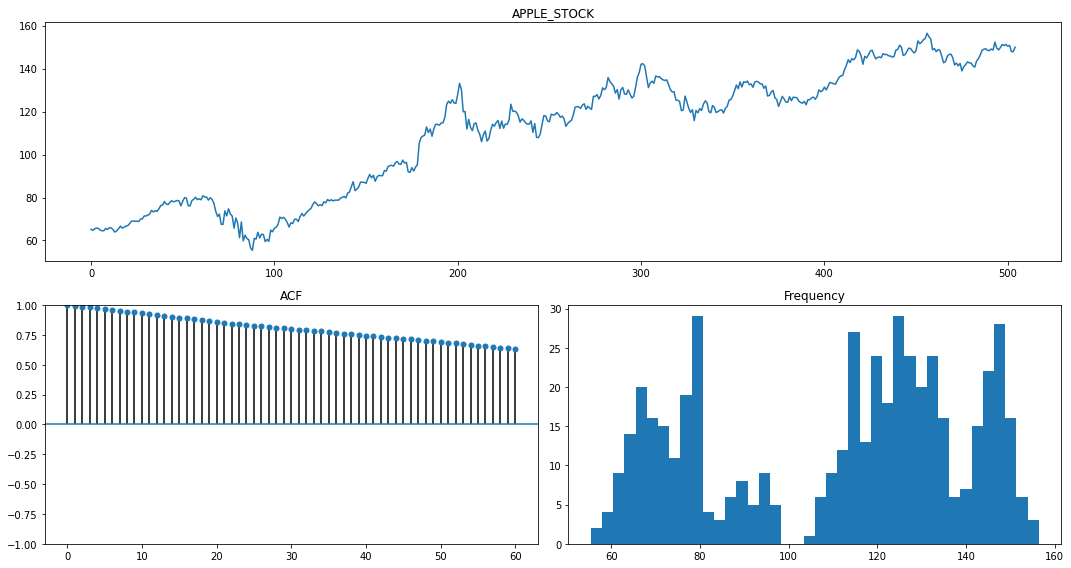

In [15]:

import yfinance as yf

apple = yf.download(tickers='AAPL',period='2y',interval='1d',rounding='3',progress=False)['Adj Close']
apple=pd.DataFrame(apple).dropna()
apple.head()

from pmdarima.utils import  tsdisplay

ts_apple= tsdisplay(apple,title='APPLE_STOCK',bins=40,figsize=(15,8),lag_max=60)
ts_apple

In [18]:
from pmdarima.utils import plot_acf,plot_pacf,acf,pacf,decomposed_plot,autocorr_plot
apple_decomposed = arima.decompose(np.ravel(apple),m=18,type_='multiplicative')
figure_kwargs = {'figsize': (20, 8)}
plot1= decomposed_plot(apple_decomposed,figure_kwargs=figure_kwargs)


acfplot=plot_acf(apple)
pacfplot=plot_pacf(apple)
autocorrplot=autocorr_plot(apple)

NameError: ignored

In [20]:
# acf(apple, nlags=50, alpha=.05)
pacf(apple, nlags=50, method= 'ywmle', alpha=.05)

(array([ 1.00000000e+00,  9.92532493e-01,  5.68513148e-02, -1.49110256e-02,
        -1.22966711e-03, -5.21256456e-03, -1.96396945e-02,  9.54612628e-03,
        -3.63887950e-02,  2.97229471e-02, -2.64149300e-02, -4.79485476e-03,
        -2.62589208e-02,  8.89511082e-03,  1.11973821e-02, -4.09769398e-03,
         7.21799071e-03, -2.97454611e-02,  8.90695205e-03, -4.39244317e-02,
         7.81961064e-03,  4.07703643e-02,  6.63143159e-03,  4.12703448e-02,
        -4.66136061e-03,  2.24398224e-02,  4.75494568e-03,  2.16230960e-02,
        -1.64915052e-02,  2.73657297e-03,  8.08115156e-03, -1.20374662e-02,
         6.00306462e-03, -2.79409563e-02,  2.82357793e-02, -3.59797828e-02,
        -1.11599494e-02, -2.66409867e-02,  1.74400123e-02, -5.11279129e-04,
         1.54936371e-02,  2.36729005e-03,  4.34407954e-03, -3.91843914e-02,
         3.00029675e-02,  2.90778434e-02, -2.60409633e-02, -2.72444737e-02,
        -2.10881823e-02, -4.68089220e-04, -3.27639784e-03]),
 array([[ 1.        ,  1.  

In [21]:
from pmdarima.arima.utils import  ndiffs,nsdiffs

diff_order_apple=ndiffs(apple,max_d=5)
diff_order_apple
diff_order_seasonal_apple=nsdiffs(apple,max_D=5,m=4)
diff_order_seasonal_apple

0

In [22]:
from pmdarima.model_selection import train_test_split
train,test=train_test_split(apple,train_size=300)


 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1389.704, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1384.303, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1385.360, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1386.950, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1388.865, Time=0.17 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1390.679, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1383.615, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1385.242, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1387.180, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1388.875, Time=0.42 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1384.955, Time=0.65 sec
 ARIMA(1,1,5)(0,0,0)[1] intercept   : AIC=1386.575, Time=0.63 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1385.206, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1387.202, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1377.884, Time=0.53 sec
 ARIMA(2,1

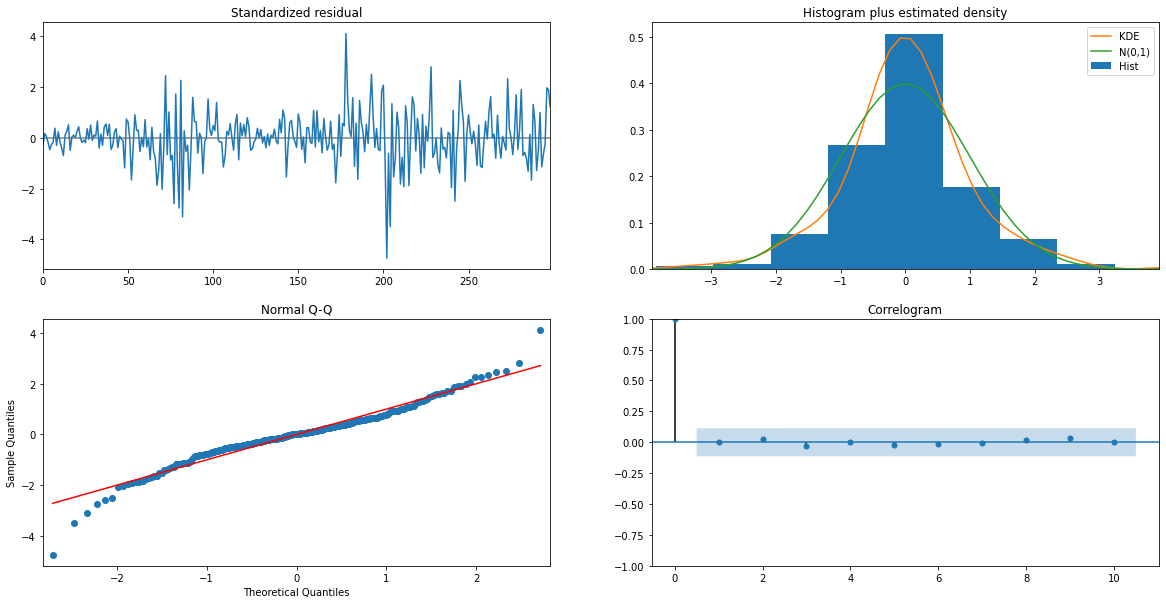

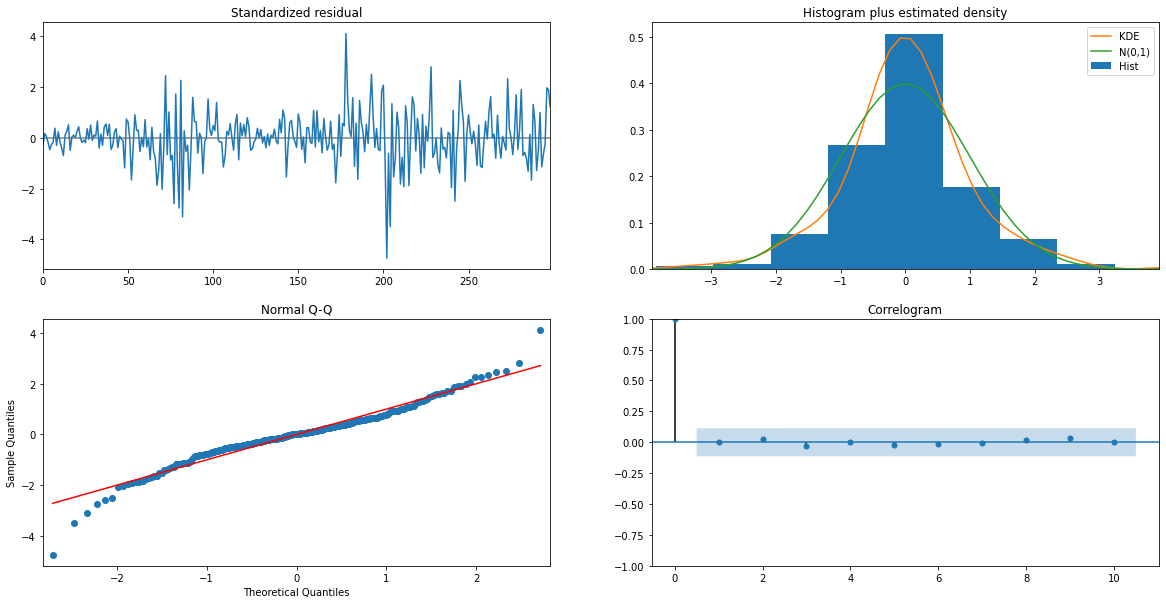

In [24]:

import pmdarima as pm

auto = pm.auto_arima(train, d=1, seasonal=True, stepwise=False,return_valid_fits=False,
                     suppress_warnings=True, error_action="ignore", max_p=4,
                      max_order=None, trace=True)
# auto.summary()

# print(auto.order)
auto.plot_diagnostics(figsize=(20,10))

In [83]:
# train.head()
train.tail()

,Adj Close
Date,
2021-01-15,126.36
2021-01-19,127.05
2021-01-20,131.22
2021-01-21,136.03
2021-01-22,138.22


In [75]:
len(test)

205

In [89]:

start_index = 2021-1-25
end_index = 2021-11-12
n_periods=len(test)

forecasted_apple1= auto.predict(start=start_index,n_periods=len(test), end=end_index,return_conf_int=False)

start_index_1 = 2019-11-13
end_index_1 = 2021-1-22

forecasted_apple= auto.predict_in_sample(start=start_index_1,end=end_index_1,n_periods=len(train),return_conf_int=False)
# pd.DataFrame(forecasted_apple).plot(figsize=(20,5))
# train.plot(figsize=(20,5))

# pd.DataFrame(forecasted_apple)

# plt.title('ARIMA FITTED')
# plt.plot(train,label='ACTUAL')
# plt.plot(forecasted_apple,label='FORECASTED')
# plt.legend(loc='best')


# forecasted_apple= auto.predict(test.shape[0]).round(3)

In [ ]:
# plt.subplot(111)
# plt.plot(test,label='Apple')
# plt.legend(loc='best')
# plt.figure(figsize=(50,50))

array([138.41479007, 138.70291184, 138.71552682, 139.37158845,
       139.078874  , 139.92273396, 139.57954966, 140.3354468 ,
       140.20354769, 140.65362205, 140.88345637, 140.95955034,
       141.53212034, 141.33504295, 142.08229596, 141.82556337,
       142.51474407, 142.42286187, 142.86325783, 143.07241704,
       143.19606016, 143.7006538 , 143.58341538, 144.24858663,
       144.0666491 , 144.69666694, 144.6420716 , 145.07055621,
       145.26579944, 145.42664841, 145.87587272, 145.82513567,
       146.4207316 , 146.30332333, 146.88110298, 146.86088701,
       147.27616143, 147.46269196, 147.65237943, 148.05668806,
       148.06119131, 148.59795493, 148.53606881, 149.06790757,
       149.07911018, 149.48057877, 149.66235127, 149.87414043,
       150.24217609, 150.29243493, 150.77957068, 150.76533188,
       151.2569167 , 151.29661417, 151.68420095, 151.86417368,
       152.09266894, 152.43155518, 152.51960065, 152.96497497,
       152.99152135, 153.44795657, 153.51332623, 153.88

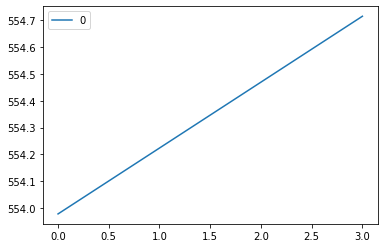

In [90]:
pd.DataFrame(forecasted_apple).plot()
forecasted_apple1

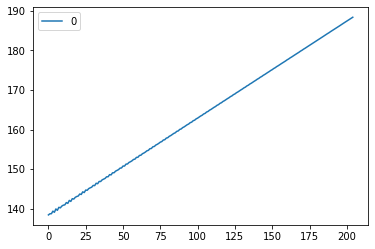

In [78]:
pd.DataFrame(forecasted_apple1).plot()



# x = np.arange(apple.shape[0])

# plt.plot(x[250:,], forecasts, c='green')
# plt.show()

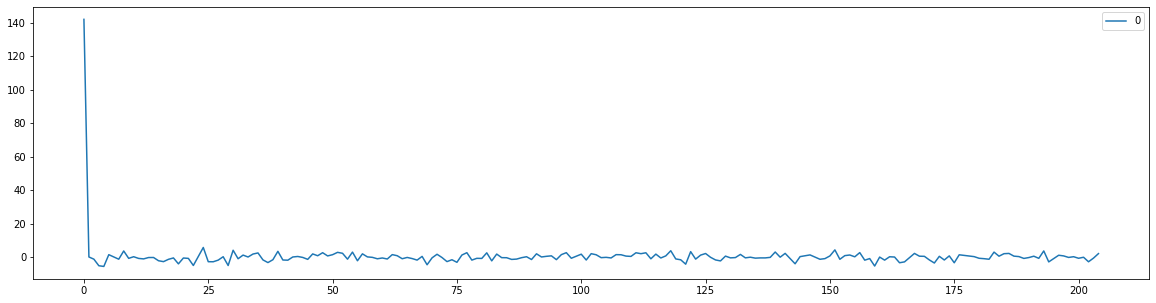

In [ ]:
residuals=auto.resid()
residuals_plot= pd.DataFrame(residuals).plot(figsize=(20,5))


In [ ]:
auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -681.633
Date:                Sun, 14 Nov 2021   AIC                           1377.266
Time:                        21:04:47   BIC                           1403.169
Sample:                             0   HQIC                          1387.633
                                - 300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0252      0.528      1.941      0.052      -0.010       2.060
ar.L1         -1.9522      0.067    -28.972      0.000      -2.084      -1.820
ar.L2         -1.1584      0.112    -10.366      0.000      -1.377      -0.939
ar.L3         -0.0997      0.056     -1.777      0.076      -0.210       0.010
ma.L1          1.8400      0.043     42.499      0.000       1.755       1.925
ma.L2          0.9406      0.043     21.958      0.000       0.857       1.025
sigma2         5.5786      0.321     17.398      0.000       4.950       6.207
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               106.04
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

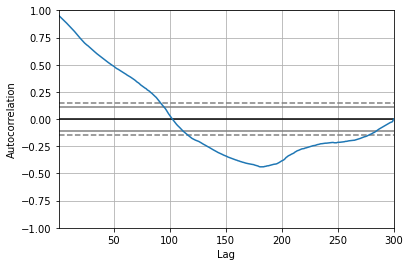

In [ ]:
autocorr_plot(forecasted_apple)

In [ ]:
# forecasts = auto.predict(n_periods=205)
# pd.DataFrame(forecasts).plot()
# test.plot()


In [ ]:
# auto.fit_predict(y=test)
# pd.DataFrame(auto.resid()).plot()


In [ ]:
# auto.pvalues()

# auto.aicc()



2256.2898805837767

In [ ]:
# auto.to_dict()

In [ ]:
# auto.bic()


2268.909705196374

In [ ]:
# # pmdarima.metrics.smape(y_true, y_pred)


# from pmdarima import model_selection.SlidingWindowForecastCV

# # Even though we have a dedicated train/test split, we can (and should) still
# # use cross-validation on our training set to get a good estimate of the model
# # performance. We can choose which model is better based on how it performs
# # over various folds.


# cv = model_selection.SlidingWindowForecastCV(window_size=100, step=24, h=1)

# model1_cv_scores = model_selection.cross_val_score(
#     model1, train, scoring='smape', cv=cv, verbose=2)

# #print("Model 1 CV scores: {}".format(model1_cv_scores.tolist()))



# model1_cv_scores




# # We can see the ACF increases and decreases rather rapidly, which means we may
# # need some differencing. There also does not appear to be an obvious seasonal
# # trend.

# from pmdarima import arima
# n_diffs = arima.ndiffs(ad_1, max_d=5)

# n_diffs


In [ ]:
# from pmdarima.arima.utils import nsdiffs
# # D= estimate number of seasonal differences using a Canova-Hansen test or use the OCSB test (by default)
# D = nsdiffs(ad_1,
#             m=10,  # commonly requires knowledge of dataset
#             max_D=12,
#             test='ch')
# D

# # By default, this will be estimated in auto_arima if seasonal=True. Make sure to pay attention to the m and the max_D parameters

In [ ]:
# The easiest way to make your data stationary in the case of 
# ARIMA models is to allow auto_arima to work its magic, 
# estimate the appropriate d value, and difference the 
# time series accordingly.
#KPSS test (auto_arima default)



In [ ]:
# from pmdarima import model_selection

# arima = pm.auto_arima(, error_action='ignore', trace=True,
#                       suppress_warnings=True, maxiter=5,
#                       seasonal=True, m=12)

In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition= seasonal_decompose(df0, model='ad')